In [39]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [40]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import mpl_toolkits
#from mpl_toolkits.basemap import Basemap
import pandas as pd
import xarray as xr
import Nio
print (Nio.__version__)
import seaborn as seabornInstance 
import sklearn

print("python version:")
import platform
print(platform.python_version())

1.5.5
python version:
3.7.3


# Load Data

In [75]:
sstdat = xr.open_dataset('http://apdrc.soest.hawaii.edu/dods/public_data/NOAA_SST/ERSST/monthly_v5')
sstdat1 = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc')
sst = sstdat['sst']
sst1 = sstdat1['sst']
print(sst)
print(sst1)

#note: lat & lon go by scale of 2 degrees

<xarray.DataArray 'sst' (time: 2004, lat: 89, lon: 180)>
[32104080 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-12-01
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes:
    long_name:  extended reconstructed sea surface temperature [degree c] 
<xarray.DataArray 'sst' (time: 1996, lat: 89, lon: 180)>
[31975920 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-04-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstru

<xarray.DataArray 'sst' ()>
array(27.35361, dtype=float32)
<xarray.DataArray 'sst' ()>
array(27.353521, dtype=float32)


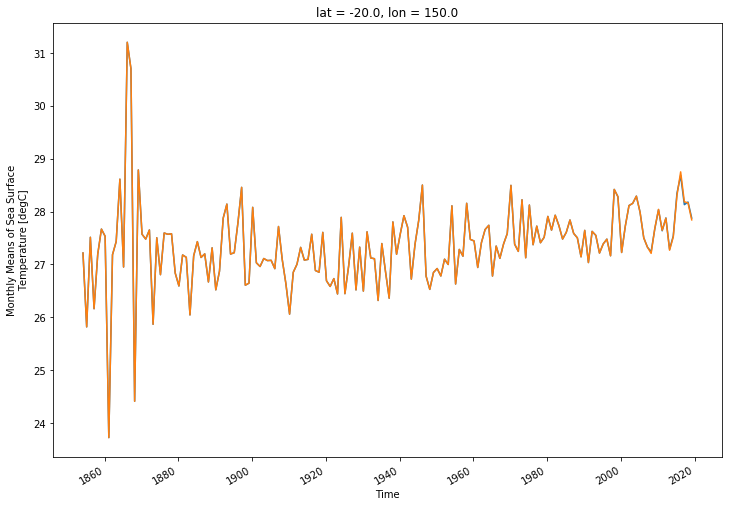

In [92]:
# comparing the two datasets
series = sst.sel(lat = slice(-20, -20), lon = slice(150, 150), time = (sst['time.month']==3)).sel(time = slice('1854-03-01', '2019-03-01'))
series1 = sst1.sel(lat = slice(-20, -20), lon = slice(150, 150), time = (sst1['time.month']==3)).sel(time = slice('1854-03-01', '2019-03-01'))
print(series.mean())
print(series1.mean())
plt.figure(figsize=(12,8))
series.plot()
series1.plot()

In [42]:
#slpdat = xr.open_dataset('ftp://ftp.cdc.noaa.gov/Datasets.other/hadslp2/slp.mnmean.real.nc')
slpdat = xr.open_dataset('data/slp.mnmean.real.nc')
print(slpdat)
slp = slpdat['slp']
slp
# https://www.metoffice.gov.uk/hadobs/hadslp2/data/hadslp2r.asc.gz
#note: lat & lon go by scale of 5 degrees

<xarray.Dataset>
Dimensions:    (lat: 37, lon: 72, nbnds: 2, time: 2040)
Coordinates:
  * lat        (lat) float32 90.0 85.0 80.0 75.0 ... -75.0 -80.0 -85.0 -90.0
  * lon        (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2019-12-01
Dimensions without coordinates: nbnds
Data variables:
    slp        (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) float64 ...
Attributes:
    title:        HadSLP2
    history:      Fri Mar  8 10:06:25 2013: ncks -d time,0,1957 slp.mnmean.re...
    comments:     adSLP2 was created using marine observations taken from ICO...
    Conventions:  CF-1.0
    platform:     Model
    source:       Hadley Center
    institution:  Hadley Center
    References:   https://www.esrl.noaa.gov/psd/data/gridded/data.hadslp2.html
    NCO:          20130308
    source_url:   https://hadobs.metoffice.com/hadslp2/


<xarray.DataArray 'slp' (time: 2040, lat: 37, lon: 72)>
[5434560 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 85.0 80.0 75.0 70.0 ... -75.0 -80.0 -85.0 -90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2019-12-01
Attributes:
    long_name:             Monthly Mean Sea Level Pressure
    unpacked_valid_range:  [ 850. 1400.]
    actual_range:          [ 953.9066 1052.5088]
    units:                 mb
    precision:             1
    var_desc:              Sea Level Pressure
    dataset:               HadSLP2
    level_desc:            Surface
    statistic:             Mean
    parent_stat:           Individual Observation
    valid_range:           [-32765  32765]

In [43]:
precipdat = xr.open_dataset('pALLIN.nc', decode_times=False)
print(precipdat)
time = pd.date_range('1874-05-01', freq='M', periods=1752)
precipALLIN = xr.Dataset({'data': ('data', precipdat['precip']), 'time': time, 'foo': ('int', np.arange(1752))})
precipALLIN

<xarray.Dataset>
Dimensions:  (time: 1752)
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 1748.0 1749.0 1750.0 1751.0
Data variables:
    precip   (time) float32 ...
Attributes:
    title:        
    description:  All-India Rainfall
    scripturl01:  https://climexp.knmi.nl/getindices.cgi?STATION=All-India_Ra...
    comment:      
    institution:  KNMI Climate Explorer
    scripturl02:  https://climexp.knmi.nl/dat2nc.cgi?id=$id&station=All-India...
    history:       2020-04-02  2:43:20 bin/dat2nc data/pALLIN.dat p All-India...
    Conventions:  CF-1.0


<xarray.Dataset>
Dimensions:  (data: 1752, int: 1752, time: 1752)
Coordinates:
  * data     (data) float32 19.6 10.7 14.5 33.9 63.6 ... 168.7 52.1 8.0 7.0
  * time     (time) datetime64[ns] 1874-05-31 1874-06-30 ... 2020-04-30
Dimensions without coordinates: int
Data variables:
    foo      (int) int64 0 1 2 3 4 5 6 7 ... 1745 1746 1747 1748 1749 1750 1751

# EPT

In [61]:
#EP-ENSOpredictor

#DSST1
latrange1 = sst.sel(lat = slice(-20, 5)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = sst.sel(lat = slice(-20, 5), lon = slice(150, 170), time = (sst['time.month']==3))
marchSST1 = marchdata1.sel(time = slice('2019-03-01', '2019-03-01'))
marchmean1 = (marchSST1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = sst.sel(lat = slice(-20, 5), lon = slice(150, 170), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('2019-05-01', '2019-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data
DSST1 = maymean1 - marchmean1

#DSST2
latrange2 = sst.sel(lat = slice(-10, 10)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = sst.sel(lat = slice(-10, 10), lon = slice(250, 280), time = (sst['time.month']==3))
marchSST2 = marchdata2.sel(time = slice('2019-03-01', '2019-03-01'))
marchmean2 = (marchSST2*weights2).mean({'lon', 'lat'})/weights2.mean()

maydata2 = sst.sel(lat = slice(-10, 10), lon = slice(250, 280), time = (sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('2019-05-01', '2019-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean()

marchmean2.time.data = maymean2.time.data
DSST2 = (maymean2 - marchmean2)

EPT = DSST1 - DSST2
EPTstd = 0.546494
EPTmean = -0.036233
EPT = (EPT - EPTmean)/EPTstd

In [62]:
print(DSST1-DSST2)
# -0.021276 (NOAA)
# -.095434 (HAWAII)

#pick a point and plot time series against the other
#print maps for given months for certain datasets

<xarray.DataArray (time: 1)>
array([-0.095434])
Coordinates:
  * time     (time) datetime64[ns] 2019-05-01


In [63]:
print(EPT)

<xarray.DataArray (time: 1)>
array([-0.108328])
Coordinates:
  * time     (time) datetime64[ns] 2019-05-01


# CPT

In [64]:
#CP-ENSOpredictor

#DSST1
latrange1 = sst.sel(lat = slice(-25, -10)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = sst.sel(lat = slice(-25, -10), lon = slice(170, 200), time = (sst['time.month']==4))
aprilSST1 = aprildata1.sel(time = slice('2019-04-01', '2019-04-01'))
aprilmean1 = (aprilSST1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = sst.sel(lat = slice(-25, -10), lon = slice(170, 200), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('2019-05-01', '2019-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean()

aprilmean1.time.data = maymean1.time.data
DSST1 = maymean1 - aprilmean1

#DSST2
latrange2 = sst.sel(lat = slice(5, 20)).lat
weights2 = np.cos(latrange2*np.pi/180)

aprildata2 = sst.sel(lat = slice(5, 20), lon = slice(180, 210), time = (sst['time.month']==4))
aprilSST2 = aprildata2.sel(time = slice('2019-04-01', '2019-04-01'))
aprilmean2 = (aprilSST2*weights2).mean({'lon', 'lat'})/weights2.mean()
                          
maydata2 = sst.sel(lat = slice(5, 20), lon = slice(180, 210), time = (sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('2019-05-01', '2019-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean()
                          
aprilmean2.time.data = maymean2.time.data
DSST2 = maymean2 - aprilmean2

CPT = DSST1 - DSST2
CPTstd = 0.243743
CPTmean = -1.087295
CPT = (CPT - CPTmean)/CPTstd

In [65]:
print(DSST1-DSST2)
# -1.286224 (NOAA)
# -1.318314 (HAWAII)

<xarray.DataArray (time: 1)>
array([-1.318314])
Coordinates:
  * time     (time) datetime64[ns] 2019-05-01


In [66]:
print(CPT)

<xarray.DataArray (time: 1)>
array([-0.947798])
Coordinates:
  * time     (time) datetime64[ns] 2019-05-01


# PSH

In [67]:
#mega-ENSOpredictor

#NPcalculation
latrange1 = slp.sel(lat = slice(-10, -40)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = slp.sel(lat = slice(-10, -40), lon = slice(200, 270), time = (slp['time.month']==4))
aprilSLP1 = aprildata1.sel(time=slice('2019-04-01','2019-04-01'))
aprilmean1 = (aprilSLP1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = slp.sel(lat = slice(-10, -40), lon = slice(200, 270), time = (slp['time.month']==5))
maySLP1 = maydata1.sel(time = slice('2019-05-01', '2019-05-01'))
maymean1 = (maySLP1*weights1).mean({'lon', 'lat'})/weights1.mean()

aprilmean1.time.data = maymean1.time.data
NP = ((aprilmean1 + maymean1)/2)

#SPcalculation
latrange2 = slp.sel(lat = slice(30, 10)).lat
weights2 = np.cos(latrange2*np.pi/180)

aprildata2 = slp.sel(lat = slice(30, 10), lon = slice(180, 230), time = (slp['time.month']==4))
aprilSLP2 = aprildata2.sel(time = slice('2019-04-01', '2019-04-01'))
aprilmean2 = (aprilSLP2*weights2).mean({'lon', 'lat'})/weights2.mean()

maydata2 = slp.sel(lat = slice(30, 10), lon = slice(180, 230), time = (slp['time.month']==5))
maySLP2 = maydata2.sel(time = slice('2019-05-01', '2019-05-01'))
maymean2 = (maySLP2*weights2).mean({'lon', 'lat'})/weights2.mean()

aprilmean2.time.data = maymean2.time.data
SP = ((aprilmean2 + maymean2)/2)

NParea = (30*weights1.mean() * 60)
SParea = (20*weights2.mean() * 50)
PSH = ((NP * NParea) + (SP * SParea))/(NParea + SParea)
PSHstd = 0.430541
PSHmean = 1015.898018
PSH = (PSH - PSHmean)/PSHstd

In [68]:
print(PSH)

<xarray.DataArray (time: 1)>
array([2.278731])
Coordinates:
  * time     (time) datetime64[ns] 2019-05-01


# NAT

In [69]:
#AnomalousAsianLowpredictor

latrange = slp.sel(lat = slice(60, 40)).lat
weights = np.cos(latrange*np.pi/180)

marchdata = slp.sel(lat = slice(60, 40), lon = slice(95, 125), time = (slp['time.month']==3))
marchSLP = marchdata.sel(time = slice('2019-03-01', '2019-03-01'))
marchmean = (marchSLP*weights).mean({'lon', 'lat'})/weights.mean()

maydata = slp.sel(lat = slice(60, 40), lon = slice(95, 125), time = (slp['time.month']==5))
maySLP = maydata.sel(time = slice('2019-05-01', '2019-05-01'))
maymean = (maySLP*weights).mean({'lon', 'lat'})/weights.mean()

marchmean.time.data = maymean.time.data
NAT = maymean - marchmean
NATstd = 1.648686
NATmean = -12.909709
NAT = (NAT - NATmean)/NATstd

In [70]:
print(NAT)

<xarray.DataArray (time: 1)>
array([1.855343], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2019-05-01


# Precipitation

In [71]:
#precipitation

junenumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 6):
        junenumber.append(x)
junedata = precipALLIN.sel(time = precipALLIN['time.month']==6, int = junenumber)
juneprecipALLIN = junedata.data[junenumber]

julynumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 7):
        julynumber.append(x)
julydata = precipALLIN.sel(time = precipALLIN['time.month']==7, int = julynumber)
julyprecipALLIN = julydata.data[julynumber]

augustnumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 8):
        augustnumber.append(x)
augustdata = precipALLIN.sel(time = precipALLIN['time.month']==8, int = augustnumber)
augustprecipALLIN = augustdata.data[augustnumber]

septembernumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 9):
        septembernumber.append(x)
septemberdata = precipALLIN.sel(time = precipALLIN['time.month']==9, int = septembernumber)
septemberprecipALLIN = septemberdata.data[septembernumber]

rainfallforAIRIfull = juneprecipALLIN.data + julyprecipALLIN.data + augustprecipALLIN.data + septemberprecipALLIN.data

rainfall = []
for y in range(89):
    rainfall.append(rainfallforAIRIfull[y+29])
print(rainfall)

rainfallstd = np.std(rainfall)
rainfallmean = np.mean(rainfall)

[889.3, 722.0, 791.80005, 860.8, 750.3, 716.4, 884.89996, 777.49994, 897.0, 889.3, 934.89996, 736.30005, 805.80005, 784.4, 898.0, 780.6, 950.6, 1004.2, 650.8, 884.5, 719.0, 865.8, 869.0, 823.0, 862.6, 803.60004, 902.6, 853.0, 767.7, 821.1, 804.4, 877.0, 803.4, 975.8, 913.39996, 843.5, 908.19995, 841.89996, 908.19995, 789.4, 853.1, 728.30005, 957.69995, 868.2001, 920.3, 910.80005, 903.60004, 945.3, 873.89996, 903.69995, 876.9, 738.8, 792.9, 922.89996, 885.30005, 930.0, 983.2, 788.5, 889.3, 944.1, 839.7, 1020.2, 809.8, 857.9, 922.5, 709.39996, 739.9, 860.1, 754.6, 831.0, 939.8, 886.8, 652.8, 913.4, 748.0, 962.7, 856.80005, 883.2, 909.30005, 707.7, 882.8, 852.19995, 735.4, 955.60004, 836.7, 759.8, 743.0, 697.1, 961.5]


# Model

In [72]:
#Dr. Wang's coefficients
AIRI = 0.47*EPT + 0.19*CPT + 0.23*PSH - 0.24*NAT
AIRI

<xarray.DataArray (time: 1)>
array([-0.15217])
Coordinates:
  * time     (time) datetime64[ns] 2019-05-01

In [73]:
final = (AIRI * rainfallstd) + rainfallmean
print(final)

# 842.063482 (NOAA)
# 834.746178 (HAWAII)

<xarray.DataArray (time: 1)>
array([834.746178])
Coordinates:
  * time     (time) datetime64[ns] 2019-05-01


In [17]:
# Copyright (c) 2020 Medha Palavalli.